# Modeling with k-fold cross validation

Given 10+ stories per categories, create a model and use 5-fold cross validation to predict story categories
The model can be a neural network, so we will have confidences, or multinomial regression, in both cases we offer potential alternative categories, because multiple categories could represent a given story

## Preprocessing data
- Add super categories

In [1]:
import json
with open('Downloads/ATU.jl') as f:
    df_li = []
    for line in f:
        j = json.loads(line)
        df_li.append(j)
        
df = pd.DataFrame(df_li)

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
df['super_category'] = pd.cut(df['atu'].str.extract('(\d+)').astype(int).squeeze(), # extract numbers and convert dtype to int
                              [-1, 299, 749, 849, 999, 1199, 1999, 2399],
                              labels=['ANIMAL TALES', # (-1, 299]
                                      'TALES OF MAGIC', # (299, 749]
                                      'RELIGIOUS TALES', # ...
                                      'REALISTIC TALES',
                                      'TALES OF THE STUPID OGRE (GIANT, DEVIL)',
                                      'ANECDOTES AND JOKES',
                                      'FORMULA TALES'])

<IPython.core.display.Javascript object>

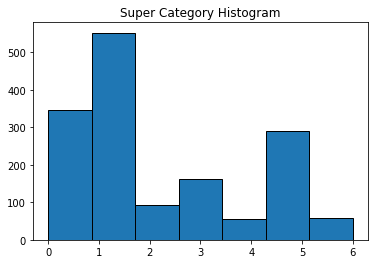

In [35]:
ax = df['super_category_codes'].hist(bins=df['super_category_codes'].nunique(), ec='black')
ax.grid(False)
ax.title.set_text('Super Category Histogram')

In [17]:
df['super_category'] = pd.Categorical(df['super_category'])
df['super_category_codes'] = df['super_category'].cat.codes
df['super_category']

<IPython.core.display.Javascript object>

0        ANIMAL TALES
1        ANIMAL TALES
2        ANIMAL TALES
3        ANIMAL TALES
4        ANIMAL TALES
            ...      
1553    FORMULA TALES
1554    FORMULA TALES
1555    FORMULA TALES
1556    FORMULA TALES
1557    FORMULA TALES
Name: super_category, Length: 1558, dtype: category
Categories (7, object): ['ANIMAL TALES' < 'TALES OF MAGIC' < 'RELIGIOUS TALES' < 'REALISTIC TALES' < 'TALES OF THE STUPID OGRE (GIANT, DEVIL)' < 'ANECDOTES AND JOKES' < 'FORMULA TALES']

In [1]:
df = pd.read_pickle('Downloads/ATUwithLF.pkl')

<IPython.core.display.Javascript object>

## Improved longformer
- Used longformer-large-4096
- Pytorch implementation
- introducing batch size and torch.no_grad() to better use of GPU memory which greatly reduced the chance of OOM error
- Uses larger dimension, 1024 instead of 768

In [4]:
import torch
def pad_to_window_size(input_ids: torch.Tensor, attention_mask: torch.Tensor,
                       one_sided_window_size: int, pad_token_id: int):
    '''A helper function to pad tokens and mask to work with the sliding_chunks implementation of Longformer selfattention.
    Input:
        input_ids = torch.Tensor(bsz x seqlen): ids of wordpieces
        attention_mask = torch.Tensor(bsz x seqlen): attention mask
        one_sided_window_size = int: window size on one side of each token
        pad_token_id = int: tokenizer.pad_token_id
    Returns
        (input_ids, attention_mask) padded to length divisible by 2 * one_sided_window_size
    '''
    import torch.nn.functional as F
    w = int(2 * one_sided_window_size)
    seqlen = input_ids.size(1)
    padding_len = (w - seqlen % w) % w
    input_ids = F.pad(input_ids, (0, padding_len), value=pad_token_id)
    attention_mask = F.pad(attention_mask, (0, padding_len), value=False)  # no attention on the padding tokens
    return input_ids, attention_mask

In [5]:
import torch, gc
from transformers import TFLongformerModel, LongformerTokenizerFast, LongformerConfig
from transformers import RobertaTokenizer, LongformerModel
from transformers import AutoTokenizer, AutoModel

config = LongformerConfig.from_pretrained('allenai/longformer-large-4096')
# choose the attention mode 'n2', 'tvm' or 'sliding_chunks'
# 'n2': for regular n2 attantion
# 'tvm': a custom CUDA kernel implementation of our sliding window attention
# 'sliding_chunks': a PyTorch implementation of our sliding window attention
config.attention_mode = 'tvm'

tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-large-4096")
model = AutoModel.from_pretrained("allenai/longformer-large-4096")
tokenizer.model_max_length = model.config.max_position_embeddings

model = model.cuda();

def LFencode(row):
    TEXT = row['text']
    input_ids = torch.tensor(tokenizer.encode(TEXT, max_length=4096, truncation=True)).unsqueeze(0) # batch of size 1

    # TVM code doesn't work on CPU. Uncomment this if `config.attention_mode = 'tvm'`
    input_ids = input_ids.cuda()

    # Attention mask values -- 0: no attention, 1: local attention, 2: global attention
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=input_ids.device) # initialize to local attention
#     attention_mask[:, [1, 4, 21,]] =  2  # Set global attention based on the task. For example,
                                         # classification: the <s> token
                                         # QA: question tokens

    # padding seqlen to the nearest multiple of 512. Needed for the 'sliding_chunks' attention
    input_ids, attention_mask = pad_to_window_size(
            input_ids, attention_mask, config.attention_window[0], tokenizer.pad_token_id)

    output = model(input_ids, attention_mask=attention_mask)

    result = output.pooler_output.cpu()
    
    return result.detach().numpy() # tensor to numpy

In [6]:
from tqdm.notebook import tqdm
tqdm.pandas()
# df['longformer_output'] = df.progress_apply(LFencode,axis=1)

import time

batch_size = 16
result = []
for batch_number, batch_df in tqdm(df.groupby(np.arange(len(df)) // batch_size)):
    # result.append(batch_df['ID'].nunique())
    with torch.no_grad(): # VERY IMPORTANT to have this, this clears the memory of every batch apply
        batch_df['longformer_output'] = batch_df.apply(LFencode, axis=1)
    result.append(batch_df)

  0%|          | 0/98 [00:00<?, ?it/s]

In [12]:
df = pd.concat(result)

<IPython.core.display.Javascript object>

In [16]:
df.to_pickle('Downloads/ATUwithLF.pkl')

## 5-fold Cross Validation - Neural Nets

In [2]:
X = np.concatenate(df['longformer_output'].to_numpy())
y = df['super_category_codes'].to_numpy()

<IPython.core.display.Javascript object>

In [3]:
print(X.shape)
print(y.shape)

(1558, 1024)
(1558,)


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler.fit_transform(X)

print(scaled_X, y)

[[0.63413596 0.4456663  0.49524045 ... 0.50179315 0.35628453 0.47142467]
 [0.8203745  0.47535574 0.36462855 ... 0.46277332 0.6610025  0.3797953 ]
 [0.60574067 0.5679672  0.4279511  ... 0.52810097 0.30722252 0.6043082 ]
 ...
 [0.7386455  0.39600325 0.32427216 ... 0.5084808  0.4033128  0.5282249 ]
 [0.49282753 0.46960258 0.22107387 ... 0.48322392 0.09316686 0.52675474]
 [0.5299714  0.2679236  0.33538485 ... 0.53706217 0.3451777  0.4605823 ]] [0 0 1 ... 1 0 3]


### Dealing with imbalanced data
Solution: Using different metrics

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)
X_test, X_eval, y_test, y_eval = train_test_split(X_test, y_test, test_size=0.5)

In [7]:
print(X_train.shape, X_test.shape, X_eval.shape)
print(y_train.shape, y_test.shape, y_eval.shape)

(1246, 1024) (156, 1024) (156, 1024)
(1246,) (156,) (156,)


I give up on the following cell...

In [470]:
def PRE_micro(y_true, y_pred):
#     squared_difference = tf.square(y_true - y_pred)
#     return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`
    TP_tf = tf.equal(y_true, y_pred)
    TP_tf = tf.reshape(TP_tf, [-1])
    
    TP = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    FP = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    
    unique_indices, new_index_positions = tf.unique(tf.reshape(y_true, [-1]))

    i = 0
    for val in tf.unstack(unique_indices):
        where = tf.where(y_true == val)
        where = tf.reshape(where, [-1])
        TPi = tf.reduce_sum(tf.cast(tf.gather(TP_tf, where), tf.float32))
        TP.write(i, TPi)
        
        FPi = tf.reduce_sum(tf.cast(tf.gather(tf.math.logical_not(TP_tf), where), tf.float32))
        FP.write(i, FPi)
        i+=1
        
    return tf.reduce_sum(tf.stack(TP)) / (tf.reduce_sum(tf.stack(TP)) + tf.reduce_sum(tf.stack(FP)))

def PRE_macro(y_true, y_pred):
#     squared_difference = tf.square(y_true - y_pred)
#     return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`
    TP_tf = tf.equal(y_true, y_pred)
    TP_tf = tf.reshape(TP_tf, [-1])
    
    PRE = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
    
    unique_indices, new_index_positions = tf.unique(tf.reshape(y_true, [-1]))
    i = 0
    for val in tf.unstack(unique_indices):
        where = tf.where(y_true == val)
        where = tf.reshape(where, [-1])
        TPi = tf.reduce_sum(tf.cast(tf.gather(TP_tf, where), tf.float32))
        FPi = tf.reduce_sum(tf.cast(tf.gather(tf.math.logical_not(TP_tf), where), tf.float32))
        
        PREi = TPi / (TPi+FPi)
        PRE.write(i, PREi)
        i += 1
        
    return tf.reduce_mean(tf.stack(PRE))

In [486]:
import tensorflow.keras as keras
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.CategoricalAccuracy(name='cat_accuracy'),
    keras.metrics.SparseCategoricalAccuracy(name='sparse_cat_accuracy'),
    keras.metrics.TopKCategoricalAccuracy(name='top_k', k=5),
#     PRE_micro,
#     PRE_macro
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    n_cat = df['super_category_codes'].nunique()
    model = keras.Sequential([
        keras.layers.Dense(
            16, activation='relu',
            input_shape=(X_train.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(n_cat, activation='softmax',
                           bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=METRICS)

    return model

In [487]:
df['super_category_codes'].nunique()

7

In [488]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

<IPython.core.display.Javascript object>

### Without init bias

In [489]:
model = make_model()
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 16)                16400     
_________________________________________________________________
dropout_36 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 7)                 119       
Total params: 16,519
Trainable params: 16,519
Non-trainable params: 0
_________________________________________________________________


In [490]:
model.predict(X_train[:10])

array([[0.22776468, 0.21393569, 0.19730502, 0.04178772, 0.08693311,
        0.03542528, 0.19684847],
       [0.2278321 , 0.22867823, 0.18053056, 0.03296838, 0.08928347,
        0.0298159 , 0.21089138],
       [0.23790574, 0.20474868, 0.18366858, 0.04131659, 0.09289884,
        0.04135191, 0.19810975],
       [0.22434384, 0.20093167, 0.20665982, 0.04504499, 0.09639455,
        0.04016279, 0.18646234],
       [0.21495444, 0.2682784 , 0.195406  , 0.04239253, 0.0725728 ,
        0.02996504, 0.17643076],
       [0.22957188, 0.20777546, 0.2018392 , 0.04255635, 0.0956448 ,
        0.04104115, 0.18157119],
       [0.22536656, 0.17590497, 0.26868433, 0.05576181, 0.07079273,
        0.04803738, 0.15545225],
       [0.24495204, 0.21333948, 0.21639763, 0.03740046, 0.08203125,
        0.03340758, 0.1724716 ],
       [0.23049897, 0.2185978 , 0.19171222, 0.04159183, 0.0956441 ,
        0.03860355, 0.18335146],
       [0.23675162, 0.18813948, 0.20678057, 0.04840578, 0.08749888,
        0.04191944, 0.1

In [491]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
import math
print("With the default bias initialization the loss should be about", -math.log(1/7))
print("Loss: {:0.4f}".format(results[0]))

With the default bias initialization the loss should be about 1.9459101490553135
Loss: 2.0521


In [492]:
def as_perc(value, total):
    return value/float(total)

grouped_count = df.groupby(['super_category_codes']).size()
initial_bias = grouped_count.apply(as_perc, total=df['super_category_codes'].count()).to_numpy()

### With init bias

In [493]:
model = make_model(output_bias=initial_bias)
model.predict(X_train[:10])

<IPython.core.display.Javascript object>

array([[0.07188553, 0.05698005, 0.06506176, 0.03358047, 0.19453092,
        0.53203905, 0.04592223],
       [0.05996474, 0.04062741, 0.05998416, 0.0248975 , 0.24349995,
        0.5312853 , 0.03974096],
       [0.07037967, 0.0319027 , 0.08217628, 0.02431443, 0.2946176 ,
        0.46834925, 0.02826017],
       [0.0657557 , 0.04503817, 0.04595721, 0.02453991, 0.19239032,
        0.57668877, 0.04962996],
       [0.05475193, 0.04416414, 0.0777797 , 0.02645856, 0.22780333,
        0.53008115, 0.0389612 ],
       [0.0655489 , 0.05387358, 0.07701661, 0.02761445, 0.21332939,
        0.52499706, 0.03761997],
       [0.11795447, 0.05319924, 0.0902392 , 0.04869634, 0.21172245,
        0.43134075, 0.04684756],
       [0.06696362, 0.04710291, 0.07427142, 0.02802566, 0.22690395,
        0.5163493 , 0.04038315],
       [0.06271685, 0.05561503, 0.0637228 , 0.02740328, 0.22873661,
        0.529289  , 0.03251645],
       [0.06242148, 0.05817706, 0.05440645, 0.02493226, 0.19363303,
        0.55975765, 0.0

In [494]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 2.5112


In [495]:
import tempfile
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

<IPython.core.display.Javascript object>

In [496]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign(np.zeros(7))
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_eval, y_eval), 
    verbose=0)

<IPython.core.display.Javascript object>

In [497]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_eval, y_eval), 
    verbose=0)

In [498]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

<IPython.core.display.Javascript object>

In [499]:
def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

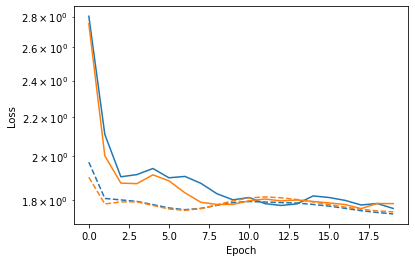

In [500]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

### Train the model

In [501]:
model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_eval, y_eval))

Epoch 1/20
1/1 [==============================] - 0s 33ms/step - loss: 1.7539 - accuracy: 0.2310 - cat_accuracy: 0.0835 - sparse_cat_accuracy: 0.3499 - top_k: 1.0000 - val_loss: 1.7471 - val_accuracy: 0.2179 - val_cat_accuracy: 0.0000e+00 - val_sparse_cat_accuracy: 0.3333 - val_top_k: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 18ms/step - loss: 1.7832 - accuracy: 0.2306 - cat_accuracy: 0.0827 - sparse_cat_accuracy: 0.3451 - top_k: 1.0000 - val_loss: 1.7456 - val_accuracy: 0.2179 - val_cat_accuracy: 0.0000e+00 - val_sparse_cat_accuracy: 0.3333 - val_top_k: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 19ms/step - loss: 1.7790 - accuracy: 0.2307 - cat_accuracy: 0.0770 - sparse_cat_accuracy: 0.3475 - top_k: 1.0000 - val_loss: 1.7462 - val_accuracy: 0.2179 - val_cat_accuracy: 0.0064 - val_sparse_cat_accuracy: 0.3333 - val_top_k: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 15ms/step - loss: 1.7711 - accuracy: 0.2292 - cat_accuracy: 0.1011 - spa

## 5-fold

In [505]:
X = np.concatenate(df['longformer_output'].to_numpy())
y = df['super_category_codes'].to_numpy()

<IPython.core.display.Javascript object>

In [507]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(scaled_X, y)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=20)

Epoch 1/20
1/1 [==============================] - 0s 1ms/step - loss: 1.8130 - accuracy: 0.2224 - cat_accuracy: 0.2665 - sparse_cat_accuracy: 0.2705 - top_k: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 1ms/step - loss: 1.8112 - accuracy: 0.2223 - cat_accuracy: 0.2825 - sparse_cat_accuracy: 0.2648 - top_k: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 833us/step - loss: 1.8102 - accuracy: 0.2223 - cat_accuracy: 0.2913 - sparse_cat_accuracy: 0.2552 - top_k: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 828us/step - loss: 1.7656 - accuracy: 0.2221 - cat_accuracy: 0.2608 - sparse_cat_accuracy: 0.2937 - top_k: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 997us/step - loss: 1.7386 - accuracy: 0.2228 - cat_accuracy: 0.1798 - sparse_cat_accuracy: 0.3074 - top_k: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 1ms/step - loss: 1.7471 - accuracy: 0.2231 - cat_accuracy: 0.1581 - sparse_cat_accuracy: 0.3090 - top_k: 1.0000
Epoc